# MAML Training

In [1]:
import torch
import torch.nn as nn
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

class Sine_Task():
    """
    A sine wave data distribution object with interfaces designed for MAML.
    """
    def __init__(self, amplitude, phase, xmin, xmax):
        self.amplitude = amplitude
        self.phase = phase
        self.xmin = xmin
        self.xmax = xmax

    def true_function(self, x):
        """
        Compute the true function on the given x.
        """
        return self.amplitude * np.sin(self.phase + x)

    def sample_data(self, size=1, noise=0.0, sort=False, gpu=False):
        """
        Sample data from this task.

        returns:
            x: the feature vector of length size
            y: the target vector of length size
        """
        x = np.random.uniform(self.xmin, self.xmax, size)
        if(sort): x = np.sort(x)
        y = self.true_function(x)
        if(noise>0): y += np.random.normal(loc=0.0, scale=noise, size=y.shape)
        x = torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y = torch.tensor(y, dtype=torch.float)
        if(gpu): return x.cuda(), y.cuda()
        else: return x, y
        
        
class Line_sine_Task():
    """
    A sine wave data distribution object with interfaces designed for MAML.
    """
    def __init__(self, slope, amplitude, phase, xmin, xmax):
        self.slope = slope
        self.amplitude = amplitude
        self.phase = phase
        self.xmin = xmin
        self.xmax = xmax

    def true_function(self, x):
        """
        Compute the true function on the given x.
        """
        return self.amplitude * np.cos(self.phase + x) + self.slope * x

    def sample_data(self, size=1, noise=0.0, sort=False, gpu=False):
        """
        Sample data from this task.

        returns:
            x: the feature vector of length size
            y: the target vector of length size
        """
        x = np.random.uniform(self.xmin, self.xmax, size)
        if(sort): x = np.sort(x)
        y = self.true_function(x)
        if(noise>0): y += np.random.normal(loc=0.0, scale=noise, size=y.shape)
        x = torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y = torch.tensor(y, dtype=torch.float)
        if(gpu): return x.cuda(), y.cuda()
        else: return x, y

class Task_Distribution():
    """
    The task distribution for sine regression tasks for MAML
    """

    def __init__(self, x_min, x_max, args, family="sine"):
        self.args = args
        self.x_min = x_min
        self.x_max = x_max
        self.family = family

    def sample_task(self):
        """
        Sample from the task distribution.

        returns:
            Sine_Task object
        """
        if(self.family=="sine"):
            amplitude = np.random.uniform(self.args["amplitude_min"], self.args["amplitude_max"])
            phase = np.random.uniform(self.args["phase_min"], self.args["phase_max"])
            return Sine_Task(amplitude, phase, self.x_min, self.x_max)
        elif(self.family=="line_sine"):
            amplitude = np.random.uniform(self.args["amplitude_min"], self.args["amplitude_max"])
            phase = np.random.uniform(self.args["phase_min"], self.args["phase_max"])
            slope = np.random.uniform(self.args["slope_min"], self.args["slope_max"])
            return Line_sine_Task(slope, amplitude, phase, self.x_min, self.x_max)
        else:
            return None

In [1]:
class MAMLModel(nn.Module):
    def __init__(self):
        super(MAMLModel, self).__init__()
        self.model = nn.Sequential(OrderedDict([
            ('l1', nn.Linear(1,40)),
            ('relu1', nn.ReLU()),
            ('l2', nn.Linear(40,40)),
            ('relu2', nn.ReLU()),
            ('l3', nn.Linear(40,1))
        ]))
        
    def forward(self, x):
        return self.model(x)
    
    def parameterised(self, x, weights):
        # like forward, but uses ``weights`` instead of ``model.parameters()``
        # it'd be nice if this could be generated automatically for any nn.Module...
        x = nn.functional.linear(x, weights[0], weights[1])
        x = nn.functional.relu(x)
        x = nn.functional.linear(x, weights[2], weights[3])
        x = nn.functional.relu(x)
        x = nn.functional.linear(x, weights[4], weights[5])
        return x

NameError: name 'nn' is not defined

In [3]:
class MAML():
    def __init__(self, model, tasks, inner_lr, meta_lr, K=10, inner_steps=1, tasks_per_meta_batch=1000):
        
        # important objects
        self.tasks = tasks
        self.model = model
        self.weights = list(model.parameters()) # the maml weights we will be meta-optimising
        self.criterion = nn.MSELoss()
        self.meta_optimiser = torch.optim.Adam(self.weights, meta_lr)
        
        # hyperparameters
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr
        self.K = K
        self.inner_steps = inner_steps # with the current design of MAML, >1 is unlikely to work well 
        self.tasks_per_meta_batch = tasks_per_meta_batch 
        
        # metrics
        self.plot_every = 10
        self.print_every = 100
        self.meta_losses = []
    
    def inner_loop(self, task):
        # reset inner model to current maml weights
        temp_weights = [w.clone() for w in self.weights]
        
        # perform training on data sampled from task
        X, y = task.sample_data(self.K, noise=0.1)
        for step in range(self.inner_steps):
            loss = self.criterion(self.model.parameterised(X, temp_weights), y[:,None]) / self.K
            
            # compute grad and update inner loop weights
            grad = torch.autograd.grad(loss, temp_weights)
            temp_weights = [w - self.inner_lr * g for w, g in zip(temp_weights, grad)]
        
        # sample new data for meta-update and compute loss
        X, y = task.sample_data(self.K, noise=0.1)
        loss = self.criterion(self.model.parameterised(X, temp_weights), y[:,None]) / self.K
        
        return loss
    
    def main_loop(self, num_iterations):
        epoch_loss = 0
        
        for iteration in range(1, num_iterations+1):
            
            # compute meta loss
            meta_loss = 0
            for i in range(self.tasks_per_meta_batch):
                task = self.tasks.sample_task()
                meta_loss += self.inner_loop(task)
            
            # compute meta gradient of loss with respect to maml weights
            meta_grads = torch.autograd.grad(meta_loss, self.weights)
            
            # assign meta gradient to weights and take optimisation step
            for w, g in zip(self.weights, meta_grads):
                w.grad = g
            self.meta_optimiser.step()
            
            # log metrics
            epoch_loss += meta_loss.item() / self.tasks_per_meta_batch
            
            if iteration % self.print_every == 0:
                print("{}/{}. loss: {}".format(iteration, num_iterations, epoch_loss / self.plot_every))
            
            if iteration % self.plot_every == 0:
                self.meta_losses.append(epoch_loss / self.plot_every)
                epoch_loss = 0

In [4]:
def loss_on_random_task(initial_model, K, num_steps, tasks, optim=torch.optim.SGD):
    """
    trains the model on a random sine task and measures the loss curve.
    
    for each n in num_steps_measured, records the model function after n gradient updates.
    """
    
    # copy MAML model into a new object to preserve MAML weights during training
    model = nn.Sequential(OrderedDict([
        ('l1', nn.Linear(1,40)),
        ('relu1', nn.ReLU()),
        ('l2', nn.Linear(40,40)),
        ('relu2', nn.ReLU()),
        ('l3', nn.Linear(40,1))
    ]))
    model.load_state_dict(initial_model.state_dict())
    criterion = nn.MSELoss()
    optimiser = optim(model.parameters(), 0.01)

    # train model on a random task
    task = tasks.sample_task()
    X, y = task.sample_data(200, noise=0.1, sort=True)    
    indices = np.arange(200)
    np.random.shuffle(indices)
    support_indices = np.sort(indices[0:K])
    query_indices = np.sort(indices[K:])
    X_support = X[support_indices]
    y_support = y[support_indices]
    X_query = X[query_indices]
    y_query = y[query_indices]
        
    for step in range(1, num_steps+1):
        loss = criterion(model(X_support), y_support[:,None]) / K
        # compute grad and update inner loop weights
        model.zero_grad()
        loss.backward()
        optimiser.step()

    #Evaluate on query set
    loss = criterion(model(X_query), y_query[:,None])       
    return loss

In [5]:
def average_losses(initial_model, n_samples, tasks, K=10, n_steps=10, optim=torch.optim.SGD):
    """
    returns the average learning trajectory of the model trained for ``n_iterations`` over ``n_samples`` tasks
    """

    #x = np.linspace(-5, 5, 2) # dummy input for test_on_new_task
    avg_losses = list()
    for i in range(n_samples):
        loss = loss_on_random_task(initial_model, K, n_steps, tasks, optim)
        avg_losses.append(loss.item())    
    return avg_losses

In [6]:
def model_functions_at_training(initial_model, X, y, sampled_steps, x_axis, optim=torch.optim.SGD, lr=0.01):
    """
    trains the model on X, y and measures the loss curve.
    
    for each n in sampled_steps, records model(x_axis) after n gradient updates.
    """
    
    # copy MAML model into a new object to preserve MAML weights during training
    model = nn.Sequential(OrderedDict([
        ('l1', nn.Linear(1,40)),
        ('relu1', nn.ReLU()),
        ('l2', nn.Linear(40,40)),
        ('relu2', nn.ReLU()),
        ('l3', nn.Linear(40,1))
    ]))
    model.load_state_dict(initial_model.state_dict())
    criterion = nn.MSELoss()
    optimiser = optim(model.parameters(), lr)

    # train model on a random task
    num_steps = max(sampled_steps)
    K = X.shape[0]
    
    losses = []
    outputs = {}
    for step in range(1, num_steps+1):
        loss = criterion(model(X), y[:,None]) / K
        losses.append(loss.item())

        # compute grad and update inner loop weights
        model.zero_grad()
        loss.backward()
        optimiser.step()

        # plot the model function
        if step in sampled_steps:
            outputs[step] = model(torch.tensor(x_axis, dtype=torch.float).view(-1, 1)).detach().numpy()
            
    outputs['initial'] = initial_model(torch.tensor(x_axis, dtype=torch.float).view(-1, 1)).detach().numpy()
    
    return outputs, losses

In [7]:
def plot_sampled_performance(initial_model, model_name, task, X, y, test_range, train_range, name, sampled_steps, optim=torch.optim.SGD, lr=0.01):    
    x_axis = np.linspace(test_range[0], test_range[1], 1000)
    sampled_steps=sampled_steps #[1,10]
    outputs, losses = model_functions_at_training(initial_model, 
                                                  X, y, 
                                                  sampled_steps=sampled_steps, 
                                                  x_axis=x_axis, 
                                                  optim=optim, lr=lr)    
    fig, ax = plt.subplots()
    true_curve = np.linspace(train_range[0], train_range[1], 1000)
    true_curve = [task.true_function(x) for x in true_curve]
    ax.plot(np.linspace(train_range[0], train_range[1], 1000), true_curve, color='blue', linewidth=2.0)
    #ax.plot(x_axis, task.true_function(x_axis), color='blue', linewidth=2.0, label='true function')
    ax.scatter(X, y, color='darkblue', marker='*', s=50, zorder=10, label='data')
    if(train_range[1]<test_range[1]):
        dotted_curve = np.linspace(train_range[1], test_range[1], 1000)
        dotted_curve = [task.true_function(x) for x in dotted_curve]
        ax.plot(np.linspace(train_range[1], test_range[1], 1000), dotted_curve, color='blue', linestyle="--", linewidth=2.0)
    
    step=sampled_steps[0]
    plt.plot(x_axis, outputs[step], color='red', linewidth=2.0,
                 label='model after {} steps'.format(sampled_steps))
    # plot losses
    plt.ylim(-6.0, 6.0)
    plt.xlim(test_range[0], test_range[1])
    plt.savefig('plot_regression_maml' + str(name) + '.png', dpi=300)

In [8]:
## Simulation Parameters
train_iterations = 10000
inner_steps_test = 50  
train_range=(-5.0, 5.0)
test_range=(-5.0, 5.0)  # This must be (-5, +10) for the out-of-range condition
family = "sine"
    
## Train phase               
#tasks = Task_Distribution(amplitude_min=0.1, amplitude_max=5.0, 
#                      phase_min=0.0, phase_max=np.pi, 
#                      x_min=train_range[0], x_max=train_range[1], 
#                      family="sine")
args_line_sine = {"amplitude_min":0.1, "amplitude_max":5.0, 
        "phase_min":0.0, "phase_max":np.pi}

tasks = Task_Distribution(x_min=train_range[0], x_max=train_range[1], 
                      args=args_line_sine, family=family)

In [9]:
maml = MAML(MAMLModel(), tasks, inner_lr=0.01, meta_lr=0.001)

In [10]:
maml.main_loop(num_iterations=train_iterations)

KeyboardInterrupt: 

In [11]:
## Test phase
K = 5
print("Test, please wait...")
mse_list = average_losses(maml.model.model, n_samples=500, tasks=tasks, K=5, n_steps=inner_steps_test, optim=torch.optim.Adam)
print("-------------------")
print("Average MSE: " + str(np.mean(mse_list)) + " +- " + str(np.std(mse_list)))
print("-------------------")

Test, please wait...
-------------------
Average MSE: 1.5352715547606348 +- 1.9125168996522348
-------------------


In [12]:
np.random.seed(2)
torch.manual_seed(2)

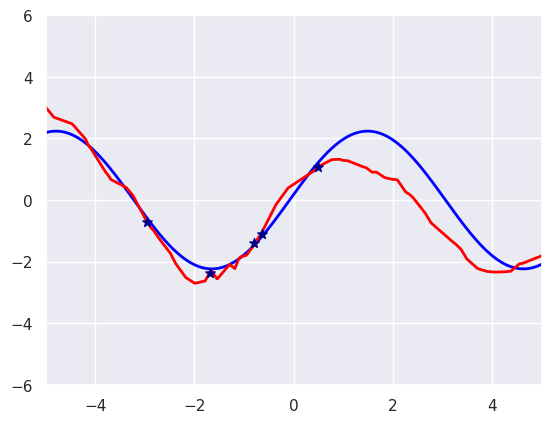

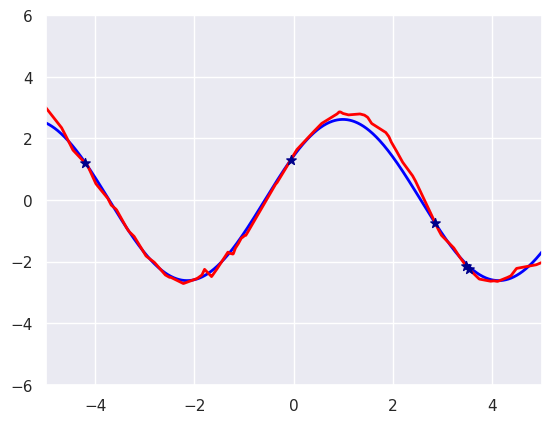

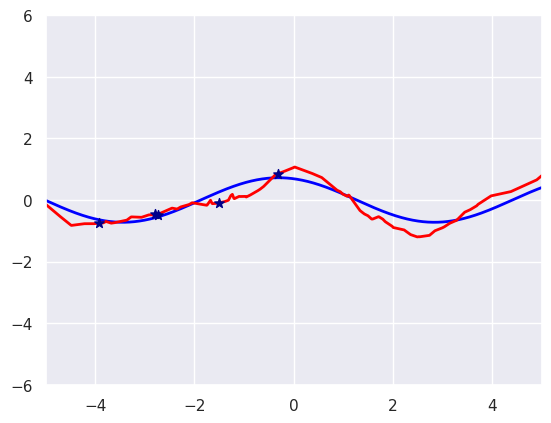

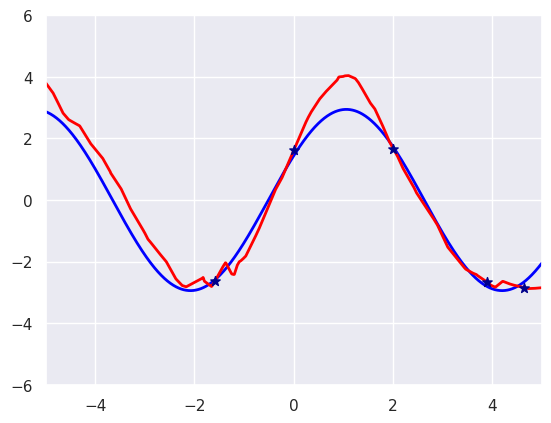

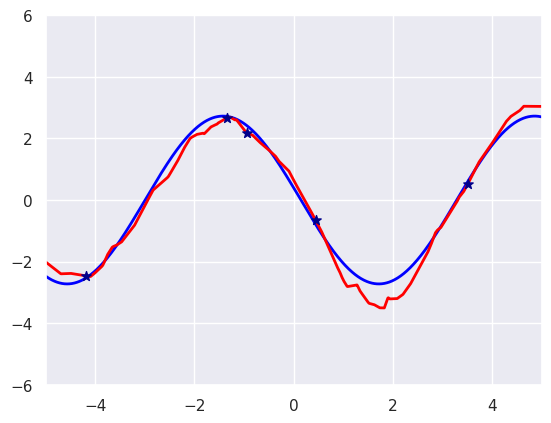

In [13]:
for i in range(5):
    task = tasks.sample_task()
    X, y = task.sample_data(K, noise=0.1)
    plot_sampled_performance(maml.model.model, 'MAML', task, X, y, test_range, train_range, name="_seed"+str(i), sampled_steps = [inner_steps_test])

In [16]:
model_params = maml.model.model.state_dict()
torch.save(model_params, 'maml_params'+str(train_iterations)+family+'.pth')

# Feature transfer with UnLiMiTD

In [10]:
model_params = torch.load('maml_params'+str(train_iterations)+family+'.pth')
maml.model.model.load_state_dict(model_params)

<All keys matched successfully>

In [14]:
import gpytorch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.func import functional_call, vmap, vjp, jvp, jacrev
device = 'cuda' if torch.cuda.device_count() > 0 else 'cpu'

sns.set()

torch.manual_seed(42)
print(device)
print(np.__version__)
print(torch.__version__)
print(gpytorch.__version__)

sigma = 10  #Hyperparam, std of w, sigma -> 0 implies sticking to the prior

cuda
1.24.3
2.0.0+cu117
1.11


In [15]:
class NTKernel(gpytorch.kernels.Kernel):
    def __init__(self, net, **kwargs):
        super(NTKernel, self).__init__(**kwargs)
        self.net = net

    def forward(self, x1, x2, diag=False, **params):
        jac1 = self.compute_jacobian(x1)
        jac2 = self.compute_jacobian(x2) if x1 is not x2 else jac1
        result = sigma * jac1@jac2.T
        
        if diag:
            return result.diag()
        return result
    
    def compute_jacobian(self, inputs):
        """
        Return the jacobian of a batch of inputs, thanks to the vmap functionality
        """
        self.zero_grad()
        params = {k: v for k, v in self.net.named_parameters()}
        def fnet_single(params, x):
            return functional_call(self.net, params, (x.unsqueeze(0),)).squeeze(0)
        
        jac = vmap(jacrev(fnet_single), (None, 0))(params, inputs)
        jac = jac.values()
        # jac1 of dimensions [Nb Layers, Nb input / Batch, dim(y), Nb param/layer left, Nb param/layer right]
        reshaped_tensors = [
            j.flatten(2)                # Flatten starting from the 3rd dimension to acount for weights and biases layers
                .permute(2, 0, 1)         # Permute to align dimensions correctly for reshaping
                .reshape(-1, j.shape[0] * j.shape[1])  # Reshape to (c, a*b) using dynamic sizing
            for j in jac
        ]
        return torch.cat(reshaped_tensors, dim=0).T

In [16]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, net):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = NTKernel(net)
        #self.covar_module = CosSimNTKernel(net)
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
        #self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4, ard_num_dims=40)
        #self.feature_extractor = feature_extractor
        
    def forward(self, x):
        #z = self.feature_extractor(x)
        #z_normalized = z - z.min(0)[0]
        #z_normalized = 2 * (z_normalized / z_normalized.max(0)[0]) - 1
        #x_normalized = x - x.min(0)[0]
        #x_normalized = 2 * (x_normalized / x_normalized.max(0)[0]) - 1
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [17]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# likelihood.noise_covar.register_constraint("raw_noise", gpytorch.constraints.GreaterThan(1e-4))
# likelihood.noise = 1e-4
n_shot_train = 5
n_shot_test = 5

dummy_inputs = torch.zeros([n_shot_train,1])
dummy_labels = torch.zeros([n_shot_train])
gp = ExactGPModel(dummy_inputs, dummy_labels, likelihood, maml.model.model)
trainable_params_gp = sum(p.numel() for p in gp.parameters() if p.requires_grad)
print(f"Trainable parameters of GP : {trainable_params_gp}")

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

Trainable parameters of GP : 1762


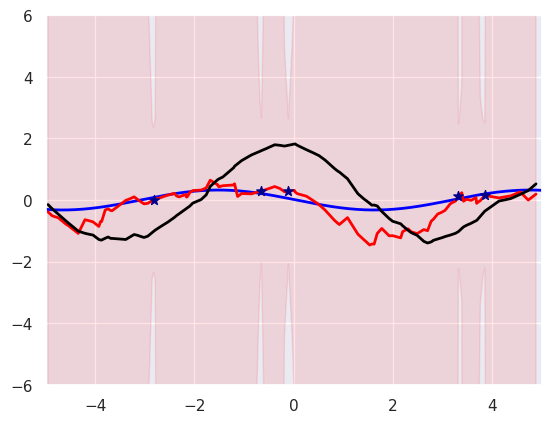

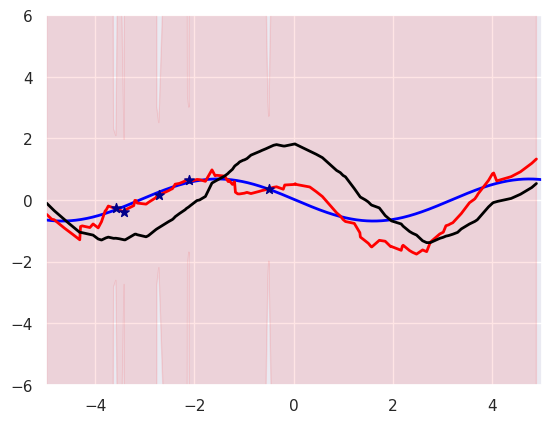

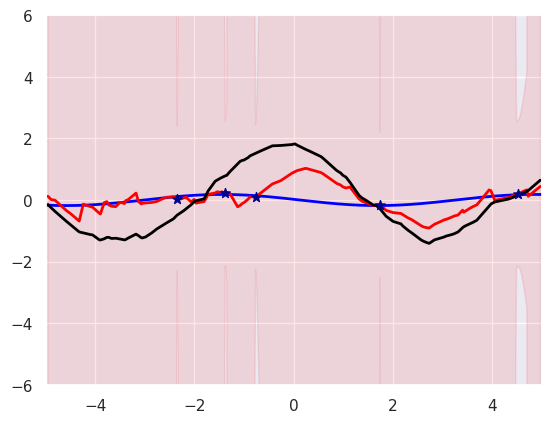

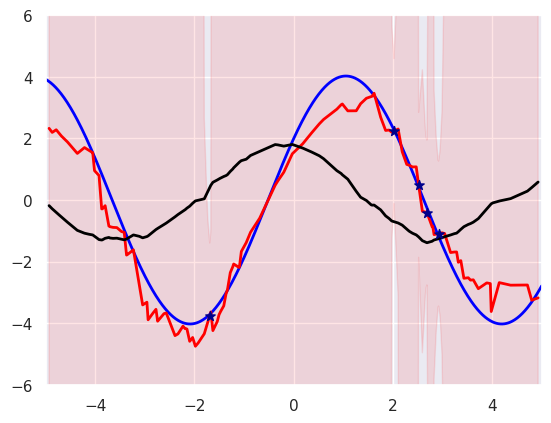

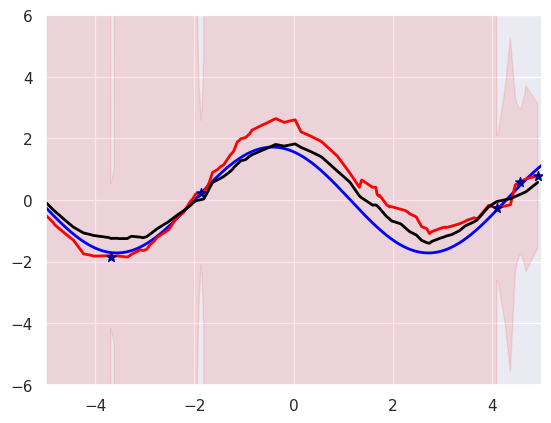

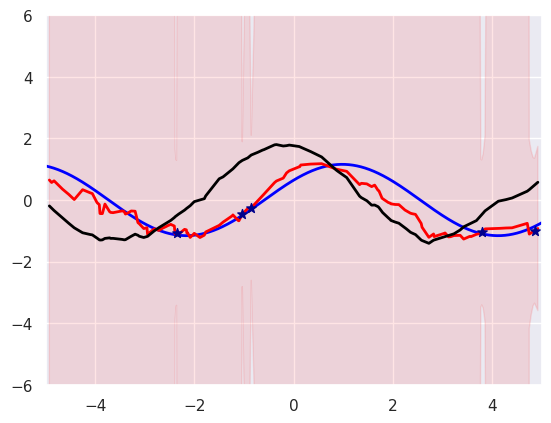

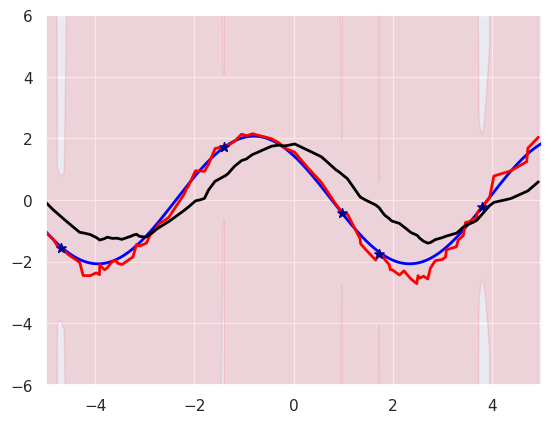

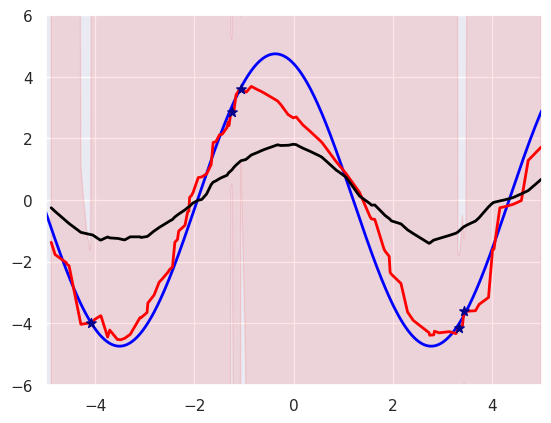

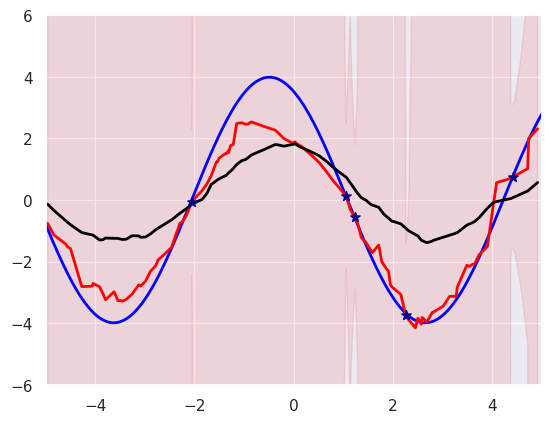

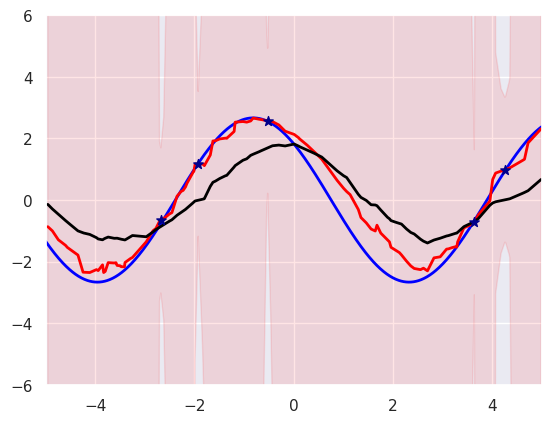

In [18]:
gp = ExactGPModel(dummy_inputs, dummy_labels, likelihood, maml.model.model)
sample_size = 200

likelihood.eval()
maml.model.model.eval()
gp.covar_module.eval()
# for param in maml.model.model.parameters():
#     param.requires_grad_(False)
    
for i in range(10):
    sample_task = tasks.sample_task()
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    indices = np.arange(sample_size)
    np.random.shuffle(indices)
    query_indices = np.sort(indices[n_shot_test:])
    support_indices = np.sort(indices[0:n_shot_test])
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]

    gp.train()
    gp.set_train_data(inputs=x_support, targets=y_support - maml.model.model(x_support).reshape(-1), strict=False)  
    gp.eval()
            
    #Evaluation on all data
    mean = likelihood(gp(x_all)).mean + maml.model.model(x_all).reshape(-1)
    lower, upper = likelihood(gp(x_all)).confidence_region() #2 standard deviations above and below the mean
    lower += maml.model.model(x_all).reshape(-1)
    upper += maml.model.model(x_all).reshape(-1)    
    
    #Plot
    fig, ax = plt.subplots()
    #true-curve
    true_curve = np.linspace(train_range[0], train_range[1], 1000)
    true_curve = [sample_task.true_function(x) for x in true_curve]
    ax.plot(np.linspace(train_range[0], train_range[1], 1000), true_curve, color='blue', linewidth=2.0)
    if(train_range[1]<test_range[1]):
        dotted_curve = np.linspace(train_range[1], test_range[1], 1000)
        dotted_curve = [sample_task.true_function(x) for x in dotted_curve]
        ax.plot(np.linspace(train_range[1], test_range[1], 1000), dotted_curve, color='blue', linestyle="--", linewidth=2.0)
    #query points (ground-truth)
    #ax.scatter(x_query, y_query, color='blue')
    #query points (predicted)

    ax.plot(np.squeeze(x_all), mean.detach().numpy(), color='red', linewidth=2.0)
    ax.plot(np.squeeze(x_all), maml.model.model(x_all).reshape(-1).detach().numpy(), color='black', linewidth=2.0)
    ax.fill_between(np.squeeze(x_all),
                    lower.detach().numpy(), upper.detach().numpy(),
                    alpha=.1, color='red')
    #support points
    ax.scatter(x_support, y_support, color='darkblue', marker='*', s=50, zorder=10)
                    
    #all points
    #ax.scatter(x_all.numpy(), y_all.numpy())
    #plt.show()
    plt.ylim(-6.0, 6.0)
    plt.xlim(test_range[0], test_range[1])
    #plt.savefig('plot_DKT_' + str(i) + '.png', dpi=300)

In [19]:
print("Test, please wait...")

likelihood.eval()
maml.model.model.eval()
tot_iterations=50
criterion = nn.MSELoss()
mse_list = list()

for epoch in range(tot_iterations):
    sample_task = tasks.sample_task()
    sample_size = 200
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    indices = np.arange(sample_size)
    np.random.shuffle(indices)
    support_indices = np.sort(indices[0:n_shot_test])

    query_indices = np.sort(indices[n_shot_test:])
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]

    #Feed the support set
    gp.train()
    gp.set_train_data(inputs=x_support, targets=y_support - maml.model.model(x_support).reshape(-1), strict=False)  
    gp.eval()

    #Evaluation on query set
    mean = likelihood(gp(x_query)).mean + maml.model.model(x_query).reshape(-1)

    mse = criterion(mean, y_query)
    mse_list.append(mse.item())

print("-------------------")
print("Average MSE: " + str(np.mean(mse_list)) + " +- " + str(np.std(mse_list)))
print("-------------------")

Test, please wait...
-------------------
Average MSE: 0.5578750820830465 +- 0.5735474960291882
-------------------


# Sketching FIM

In [ ]:
for param in maml.model.model.parameters():
    param.requires_grad_(False)

In [ ]:
def low_rank_approx(Y, W, Psi):
    """
    given Y = A @ Om, (N, k)
    and W = Psi @ A, (l, M)
    and Psi(X) = Psi @ X, (N,...) -> (l,...)
    where Om and Psi and random sketching operators
    returns Q (N x k), X (k x M) such that A ~= QX
    """
    # Perform QR decomposition on Y to get orthonormal basis Q
    Q, _ = torch.linalg.qr(Y, mode='reduced')
    
    # Apply Psi to Q and then perform QR decomposition
    U, T = torch.linalg.qr(torch.matmul(Psi, Q), mode='reduced')
    
    # Solve the triangular system T @ X = U^T @ W for X
    # PyTorch does not have a direct equivalent to scipy.linalg.solve_triangular,
    # so we use torch.linalg.solve which can handle triangular matrices if specified.
    X = torch.linalg.solve(T, torch.matmul(U.T, W))
    
    return Q, X

In [ ]:
def sym_low_rank_approx(Y, W, Psi):
    """
    Perform a symmetric low-rank approximation of the matrix A.
    """
    Q, X = low_rank_approx(Y, W, Psi)  # Assuming Psi is now correctly handled
    k = Q.shape[-1]  # Dimension of the sketches
    
    # Concatenate Q and X.T along columns to form a larger matrix
    tmp = torch.cat((Q, X.T), dim=1)  # Correctly access the transpose
    
    # Perform QR decomposition on the concatenated matrix
    U, T = torch.linalg.qr(tmp, mode='reduced')
    
    # Extract T1 and T2 from T
    T1 = T[:, :k]
    T2 = T[:, k:2*k]
    
    # Compute symmetric matrix S
    S = (T1 @ T2.T + T2 @ T1.T) / 2
    
    return U, S

# Example usage
N, k, l = 100, 10, 50  # Example dimensions
Y = torch.randn(N, k)  # Random Y matrix
W = torch.randn(l, N)  # Random W matrix
Psi = torch.randn(l, N)  # Random Psi matrix

# Call the function
U, S = sym_low_rank_approx(Y, W, Psi)

In [ ]:
def fixed_rank_eig_approx(Y, W, psi, r):
    """
    Returns U (N x r), D (r) such that A ~= U diag(D) U^T using PyTorch.
    """
    # Obtain symmetric low-rank approximation
    U, S = sym_low_rank_approx(Y, W, psi)
    
    # Compute eigenvalues and eigenvectors
    D, V = torch.linalg.eigh(S)
    
    # Truncate to keep the top-r eigenvalues and corresponding eigenvectors
    D = D[-r:]  # Top r eigenvalues
    V = V[:, -r:]  # Corresponding eigenvectors
    
    # Update U to be U @ V
    U = U @ V
    
    return U, D

# Example usage
N, k, l, r = 100, 10, 50, 5  # Example dimensions
Y = torch.randn(N, k)  # Random Y matrix
W = torch.randn(l, N)  # Random W matrix
Psi = torch.randn(l, N)  # Random Psi matrix

# Call the function
U, D = fixed_rank_eig_approx(Y, W, Psi, r)

In [ ]:
def sketch(net, batches, k, l):
    """
    Returns a good rank 2k approximation of the FIM using PyTorch.
    """
    M = batches.size(0)
    N_params = sum(p.numel() for p in net.parameters())
    print(N_params)

    om = torch.randn(k, N_params)
    psi = torch.randn(l, N_params)

    Y = torch.zeros(N_params, k)
    W = torch.zeros(l, N_params)

    for batch in batches:
        JT = jacobian(net, batch).T
        Y += (om @ JT @ JT.T).T / M
        W += (psi @ JT @ JT.T) / M

    # Compute the rank-2k approximation
    U, D = fixed_rank_eig_approx(Y, W, psi, 2 * k)

    return U, D

def jacobian(net, batch):
    """
    Compute the Jacobian for the batch. This needs to be adapted based on the actual function.
    """
    net.zero_grad()
    params = {k: v for k, v in net.named_parameters()}
    def fnet_single(params, x):
        return functional_call(net, params, (x.unsqueeze(0),)).squeeze(0)
        
    jac = vmap(jacrev(fnet_single), (None, 0))(params, batch)
    jac = jac.values()
    # jac1 of dimensions [Nb Layers, Nb input / Batch, dim(y), Nb param/layer left, Nb param/layer right]
    reshaped_tensors = [
        j.flatten(2)                # Flatten starting from the 3rd dimension to acount for weights and biases layers
            .permute(2, 0, 1)         # Permute to align dimensions correctly for reshaping
            .reshape(-1, j.shape[0] * j.shape[1])  # Reshape to (c, a*b) using dynamic sizing
        for j in jac
    ]
    return torch.cat(reshaped_tensors, dim=0)

In [ ]:
import time

def proj_sketch(net, batches, subspace_dimension):
    t = time.time_ns()

    T = 6 * subspace_dimension + 4 
    k = (T - 1) // 3                    # k = 2 * subspace_dimension + 1
    l = T - k                           # l = 4 * subspace_dimension + 3

    U, D = sketch(net, batches, k, l)
    idx = D.argsort(descending=True)
    print("U shape:", U.shape)
    print("Index tensor:", idx)
    print("Requested subspace dimension:", subspace_dimension)
    
    # Ensure idx is of type long for indexing
    # idx = idx.long()

    P1 = U[:, idx[:subspace_dimension]].T

    print(f"Done sketching in {(time.time_ns() - t) / 1e9:.4f} s")

    return P1

In [ ]:
subspace_dimension = 10

print("Finding projection matrix")
# here we use the exact FIM, we do not need to approximate given the (small) size of the network
# P1 = fim.proj_exact(key=key_fim, apply_fn=apply_fn, current_params=pre_state.params, current_batch_stats=pre_state.batch_stats, subspace_dimension=subspace_dimension)


# Generate batches in the range [-5, 5]
batch_size = 100
input_dimensions = sum(p.numel() for p in maml.model.model.parameters())
batches = 10 * torch.rand(batch_size, input_dimensions, 1) - 5  # Scaled from [0, 1] to [-5, 5]

# Call the projection sketch function
P1 = proj_sketch(net=maml.model.model, batches=batches, subspace_dimension=subspace_dimension)

# Still part of the computation graph ; detach it :
P1 = P1.detach()
print(f"PROJECTION MATRIX : {P1}")
print("Found projection matrix")

# UNLiMiTDproj feature transfer, no training

In [ ]:
class NTKernel_proj(gpytorch.kernels.Kernel):
    def __init__(self, net, subspace_dimension, P1, **kwargs):
        super(NTKernel_proj, self).__init__(**kwargs)
        self.net = net
        self.sub_dim = subspace_dimension
        self.P1 = P1 # Projection matrix
        
        # Add 10 scaling parameters, initializing them as one
        self.scaling_param = nn.Parameter(torch.ones(subspace_dimension))

    def forward(self, x1, x2, diag=False, **params):
        jac1 = self.compute_jacobian(x1)
        jac2 = self.compute_jacobian(x2) if x1 is not x2 else jac1
        D = torch.diag(torch.pow(self.scaling_param, 2))
        
        # print("jac1.T shape:", jac1.T.shape)
        # print("P1 shape:", P1.T.shape)
        # print("D shape:", D.shape)
        # print("P1.T shape:", P1.shape)
        # print("jac2 shape:", jac2.shape)
        
        result = sigma * torch.chain_matmul(jac1, P1.T, D, P1, jac2.T)
        
        if diag:
            return result.diag()
        return result
    
    def compute_jacobian(self, inputs):
        """
        Return the jacobian of a batch of inputs, thanks to the vmap functionality
        """
        self.zero_grad()
        params = {k: v for k, v in self.net.named_parameters()}
        def fnet_single(params, x):
            return functional_call(self.net, params, (x.unsqueeze(0),)).squeeze(0)
        
        jac = vmap(jacrev(fnet_single), (None, 0))(params, inputs)
        jac = jac.values()
        # jac1 of dimensions [Nb Layers, Nb input / Batch, dim(y), Nb param/layer left, Nb param/layer right]
        reshaped_tensors = [
            j.flatten(2)                # Flatten starting from the 3rd dimension to acount for weights and biases layers
                .permute(2, 0, 1)         # Permute to align dimensions correctly for reshaping
                .reshape(-1, j.shape[0] * j.shape[1])  # Reshape to (c, a*b) using dynamic sizing
            for j in jac
        ]
        return torch.cat(reshaped_tensors, dim=0).T

In [ ]:
class ExactGPModel_proj(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, net, subspace_dimension, P1):
        super(ExactGPModel_proj, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = NTKernel_proj(net, subspace_dimension, P1)
        #self.covar_module = CosSimNTKernel_proj(net, subspace_dimension, P1)
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
        #self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4, ard_num_dims=40)
        #self.feature_extractor = feature_extractor
        
    def forward(self, x):
        #z = self.feature_extractor(x)
        #z_normalized = z - z.min(0)[0]
        #z_normalized = 2 * (z_normalized / z_normalized.max(0)[0]) - 1
        #x_normalized = x - x.min(0)[0]
        #x_normalized = 2 * (x_normalized / x_normalized.max(0)[0]) - 1
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
maml.model.model.train()
for param in maml.model.model.parameters():
    param.requires_grad_(False)

# likelihood.noise_covar.register_constraint("raw_noise", gpytorch.constraints.GreaterThan(1e-4))
# likelihood.noise = 1e-4
dummy_inputs = torch.zeros([n_shot_train,1])
dummy_labels = torch.zeros([n_shot_train])
gp = ExactGPModel_proj(dummy_inputs, dummy_labels, likelihood, maml.model.model, subspace_dimension, P1)
trainable_params = sum(p.numel() for p in gp.parameters() if p.requires_grad)
print(trainable_params)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)
optimizer = torch.optim.Adam([{'params': gp.parameters(), 'lr': 1e-3}])

In [ ]:
sample_size = 200

likelihood.eval()
maml.model.model.eval()
gp.covar_module.eval()
# for param in maml.model.model.parameters():
#     param.requires_grad_(False)
    
for i in range(10):
    sample_task = tasks.sample_task()
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    indices = np.arange(sample_size)
    np.random.shuffle(indices)
    query_indices = np.sort(indices[n_shot_test:])
    support_indices = np.sort(indices[0:n_shot_test])
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]

    gp.train()
    gp.set_train_data(inputs=x_support, targets=y_support - maml.model.model(x_support).reshape(-1), strict=False)  
    gp.eval()
            
    #Evaluation on all data
    mean = likelihood(gp(x_all)).mean + maml.model.model(x_all).reshape(-1)
    lower, upper = likelihood(gp(x_all)).confidence_region() #2 standard deviations above and below the mean
    lower += maml.model.model(x_all).reshape(-1)
    upper += maml.model.model(x_all).reshape(-1)    
    
    #Plot
    fig, ax = plt.subplots()
    #true-curve
    true_curve = np.linspace(train_range[0], train_range[1], 1000)
    true_curve = [sample_task.true_function(x) for x in true_curve]
    ax.plot(np.linspace(train_range[0], train_range[1], 1000), true_curve, color='blue', linewidth=2.0)
    if(train_range[1]<test_range[1]):
        dotted_curve = np.linspace(train_range[1], test_range[1], 1000)
        dotted_curve = [sample_task.true_function(x) for x in dotted_curve]
        ax.plot(np.linspace(train_range[1], test_range[1], 1000), dotted_curve, color='blue', linestyle="--", linewidth=2.0)
    #query points (ground-truth)
    #ax.scatter(x_query, y_query, color='blue')
    #query points (predicted)

    ax.plot(np.squeeze(x_all), mean.detach().numpy(), color='red', linewidth=2.0)
    ax.plot(np.squeeze(x_all), maml.model.model(x_all).reshape(-1).detach().numpy(), color='black', linewidth=2.0)
    ax.fill_between(np.squeeze(x_all),
                    lower.detach().numpy(), upper.detach().numpy(),
                    alpha=.1, color='red')
    #support points
    ax.scatter(x_support, y_support, color='darkblue', marker='*', s=50, zorder=10)
                    
    #all points
    #ax.scatter(x_all.numpy(), y_all.numpy())
    #plt.show()
    plt.ylim(-6.0, 6.0)
    plt.xlim(test_range[0], test_range[1])
    #plt.savefig('plot_DKT_' + str(i) + '.png', dpi=300)

In [ ]:
print("Test, please wait...")

likelihood.eval()
maml.model.model.eval()
tot_iterations=500
mse_list = list()
criterion = nn.MSELoss()
for epoch in range(tot_iterations):
    sample_task = tasks.sample_task()
    sample_size = 200
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    indices = np.arange(sample_size)
    np.random.shuffle(indices)
    support_indices = np.sort(indices[0:n_shot_test])

    query_indices = np.sort(indices[n_shot_test:])
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]

    #Feed the support set
    gp.train()
    gp.set_train_data(inputs=x_support, targets=y_support - maml.model.model(x_support).reshape(-1), strict=False)  
    gp.eval()

    #Evaluation on query set
    mean = likelihood(gp(x_query)).mean + maml.model.model(x_query).reshape(-1)

    mse = criterion(mean, y_query)
    mse_list.append(mse.item())

print("-------------------")
print("Average MSE: " + str(np.mean(mse_list)) + " +- " + str(np.std(mse_list)))
print("-------------------")

# Training UNLIMITD-F

In [ ]:
sigma = 1

In [ ]:
maml.model.model.train()
for param in maml.model.model.parameters():
    param.requires_grad_(True)
gp.train()
likelihood.train()

optimizer = torch.optim.Adam([{'params': gp.parameters(), 'lr': 1e-3}])

In [ ]:
tot_iterations=50000
for epoch in range(tot_iterations):
    # gp.likelihood.noise = 1e-2
    optimizer.zero_grad()
    inputs, labels = tasks.sample_task().sample_data(n_shot_train, noise=0.05)
    
    gp.set_train_data(inputs=inputs, targets=labels - maml.model.model(inputs).reshape(-1))  
    predictions = gp(inputs)
    loss = -mll(predictions, gp.train_targets)
    loss.backward()
    optimizer.step()
    #---- print some stuff ----
    if(epoch%1000==0):
        mse = criterion(predictions.mean, labels)
        print(predictions.mean)
        print('[%d] - Loss: %.3f  MSE: %.3f  lengthscale: %.3f   noise: %.3f' % (
            epoch, loss.item(), mse.item(),
            0.0, #gp.covar_module.base_kernel.lengthscale.item(),
            gp.likelihood.noise.item()
        ))

# Testing new UNLIMITD-F

In [ ]:
sample_size = 200

likelihood.eval()
maml.model.model.eval()
gp.covar_module.eval()
# for param in maml.model.model.parameters():
#     param.requires_grad_(False)
    
for i in range(10):
    sample_task = tasks.sample_task()
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    indices = np.arange(sample_size)
    np.random.shuffle(indices)
    query_indices = np.sort(indices[n_shot_test:])
    support_indices = np.sort(indices[0:n_shot_test])
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]

    gp.train()
    gp.set_train_data(inputs=x_support, targets=y_support - maml.model.model(x_support).reshape(-1), strict=False)  
    gp.eval()
            
    #Evaluation on all data
    mean = likelihood(gp(x_all)).mean + maml.model.model(x_all).reshape(-1)
    lower, upper = likelihood(gp(x_all)).confidence_region() #2 standard deviations above and below the mean
    lower += maml.model.model(x_all).reshape(-1)
    upper += maml.model.model(x_all).reshape(-1)    
    
    #Plot
    fig, ax = plt.subplots()
    #true-curve
    true_curve = np.linspace(train_range[0], train_range[1], 1000)
    true_curve = [sample_task.true_function(x) for x in true_curve]
    ax.plot(np.linspace(train_range[0], train_range[1], 1000), true_curve, color='blue', linewidth=2.0)
    if(train_range[1]<test_range[1]):
        dotted_curve = np.linspace(train_range[1], test_range[1], 1000)
        dotted_curve = [sample_task.true_function(x) for x in dotted_curve]
        ax.plot(np.linspace(train_range[1], test_range[1], 1000), dotted_curve, color='blue', linestyle="--", linewidth=2.0)
    #query points (ground-truth)
    #ax.scatter(x_query, y_query, color='blue')
    #query points (predicted)

    ax.plot(np.squeeze(x_all), mean.detach().numpy(), color='red', linewidth=2.0)
    ax.plot(np.squeeze(x_all), maml.model.model(x_all).reshape(-1).detach().numpy(), color='black', linewidth=2.0)
    ax.fill_between(np.squeeze(x_all),
                    lower.detach().numpy(), upper.detach().numpy(),
                    alpha=.1, color='red')
    #support points
    ax.scatter(x_support, y_support, color='darkblue', marker='*', s=50, zorder=10)
                    
    #all points
    #ax.scatter(x_all.numpy(), y_all.numpy())
    #plt.show()
    plt.ylim(-6.0, 6.0)
    plt.xlim(test_range[0], test_range[1])
    #plt.savefig('plot_DKT_' + str(i) + '.png', dpi=300)

In [ ]:
print("Test, please wait...")

likelihood.eval()
maml.model.model.eval()
tot_iterations=500
mse_list = list()
for epoch in range(tot_iterations):
    sample_task = tasks.sample_task()
    sample_size = 200
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    indices = np.arange(sample_size)
    np.random.shuffle(indices)
    support_indices = np.sort(indices[0:n_shot_test])

    query_indices = np.sort(indices[n_shot_test:])
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]

    #Feed the support set
    gp.train()
    gp.set_train_data(inputs=x_support, targets=y_support - maml.model.model(x_support).reshape(-1), strict=False)  
    gp.eval()

    #Evaluation on query set
    mean = likelihood(gp(x_query)).mean + maml.model.model(x_query).reshape(-1)

    mse = criterion(mean, y_query)
    mse_list.append(mse.item())

print("-------------------")
print("Average MSE: " + str(np.mean(mse_list)) + " +- " + str(np.std(mse_list)))
print("-------------------")